In [97]:
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

import pytesseract

In [242]:
image = cv2.imread("magicien.jpeg")

In [251]:
image = cv2.imread("image.jpg")

In [249]:
image = cv2.imread("gardien.jpg")

In [247]:
image = cv2.imread("image_1.jpeg")

Approx 4
SGX2-FREO6



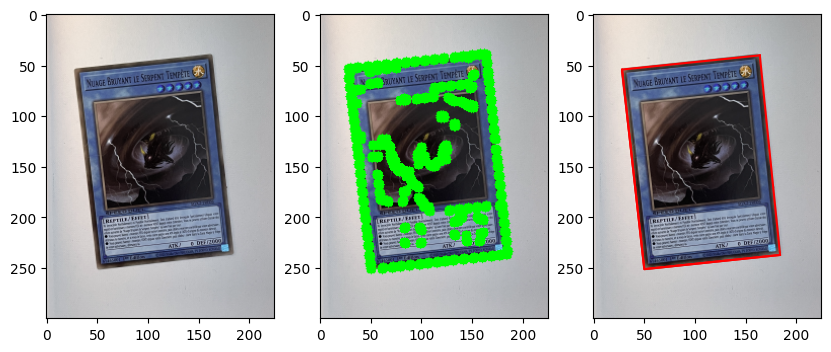

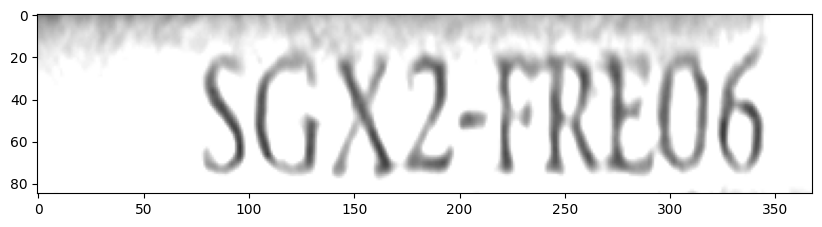

In [252]:

resizeHeight = 300
ratio = image.shape[0] / 300.0
orig = image.copy()
image = imutils.resize(image, height = resizeHeight)

gray = image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 30, 25, 30)
edged = cv2.Canny(gray, 240, 255)
ret,edged = cv2.threshold(edged,200,400,cv2.THRESH_BINARY)
kernel = np.ones((5,5),np.uint8)
edged = cv2.dilate(edged,kernel,iterations = 3)
edged = cv2.erode(edged,kernel,iterations = 3)

cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
image_copy = image.copy()
for contour in cnts:
       cv2.drawContours(image_copy, contour, -1, (0, 255, 0), 10)

screenCntList = []

for c in cnts:

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        
        if len(approx) == 4:
                print('Approx 4')
                #screenCnt = approx
                screenCntList.append(approx)
                break
        
plt.figure(figsize=(10,10));
ax0, ax1, ax2= plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)
ax0.imshow(image);
ax1.imshow(image_copy);
ax2.imshow(image);
ax2.plot([(screenCntList[0][0][0][0],screenCntList[0][1][0][0]), (screenCntList[0][1][0][0],screenCntList[0][2][0][0]), 
          (screenCntList[0][2][0][0],screenCntList[0][3][0][0]), (screenCntList[0][3][0][0],screenCntList[0][0][0][0])], 
         [(screenCntList[0][0][0][1],screenCntList[0][1][0][1]), (screenCntList[0][1][0][1],screenCntList[0][2][0][1]), 
          (screenCntList[0][2][0][1],screenCntList[0][3][0][1]), (screenCntList[0][3][0][1],screenCntList[0][0][0][1])], c='r');

for i,screenCnt in enumerate(screenCntList):
    
        pts = screenCnt.reshape(4, 2)
        rect = np.zeros((4, 2), dtype = "float32")

        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        rect *= ratio

        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

        maxWidth = max(int(widthA), int(widthB))
        maxHeight = max(int(heightA), int(heightB))

        dst = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]], dtype = "float32")

        M = cv2.getPerspectiveTransform(rect, dst)
        warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

        warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)

        warpImg = cv2.resize(warp, (2200,3000))
        (h, w) = warpImg.shape
        (dX, dY) = (int(w *.6), int(h * 0.05))
        crop = warpImg[2050:2150+dY, w-dX :w + dX ]

cv2.imwrite('crop.jpg',crop)
crop = cv2.imread('crop.jpg')
(H, W) = crop.shape[:2]

(newW, newH) = 960, 320
rW = W / float(newW)
rH = H / float(newH)

image = cv2.resize(crop, (newW, newH))
(H, W) = image.shape[:2]

layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

net = cv2.dnn.readNet("frozen_east_text_detection.pb")

blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

for y in range(0, numRows):

	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	for x in range(0, numCols):

		if scoresData[x] < .5:
			continue

		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)

		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

boxes = non_max_suppression(np.array(rects), probs=confidences)
global_box = max(boxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))

crop = image[global_box[1]-10:global_box[3]+10, global_box[0]-20:global_box[2]+20]
if np.mean(crop) < 100:
        crop = cv2.addWeighted( crop, 3, crop, 0, 30)
mrz = pytesseract.image_to_string(crop, config='--psm 6, -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-') 

plt.figure(figsize=(10,10));
ax4 = plt.subplot(1,1,1);

ax4.imshow(crop, cmap='gray')
print(mrz)


